# Respiratory Condition Radiography Model

Includes Covid-19, Viral Pneumonia, and Metastasis (Lung Opacity)

In [9]:
import os
import imageio
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import shutil

import scipy.ndimage as ndi
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow.keras.backend as tfback
from keras.regularizers import l1, l2
from keras.utils.vis_utils import plot_model
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, SeparableConv2D
from tensorflow.keras.optimizers import SGD, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

%matplotlib inline
#Kaggle notebook input directory
input_path = 'Dataset/COVID_Radiography_Dataset/'

## Dataset

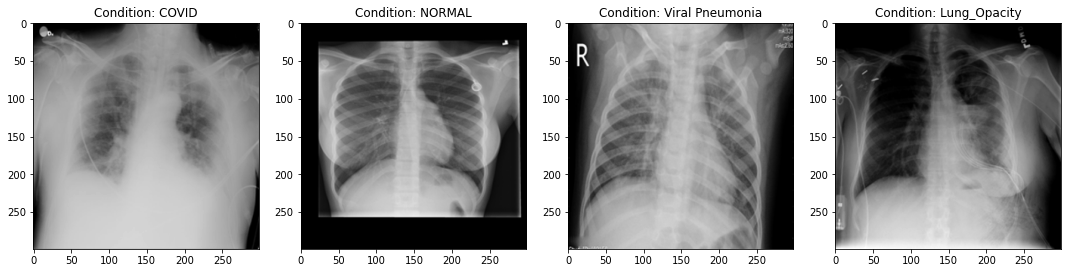

In [139]:
#Ploting some samples

fig, ax = plt.subplots(1, 4, figsize=(15, 7))
ax=ax.ravel()
plt.tight_layout()

for i,_dir in enumerate(['COVID/', 'NORMAL/', 'Viral Pneumonia/', 'Lung_Opacity/']):
    im_file = os.listdir(input_path+_dir)[0]
    full_path = input_path+_dir+im_file
    ax[i].imshow(plt.imread(full_path), cmap='gray')
    ax[i].set_title('Condition: {}'.format(_dir[:-1]))

Checking how many samples we have for each condition and total files:

In [140]:
n_covid = len(os.listdir(input_path + 'COVID/'))
n_normal = len(os.listdir(input_path + 'NORMAL/'))
n_pneumonia = len(os.listdir(input_path + 'Viral Pneumonia'))
n_metastasis = len(os.listdir(input_path + 'Lung_Opacity')) # Lung_Opacity
print(f'COVID: {n_covid} images, Normal: {n_normal} images, Pneumonia: {n_pneumonia} images, Metastasis: {n_metastasis} \nTotal images: {(n_covid+n_normal+n_pneumonia+n_metastasis)}.')

COVID: 3616 images, Normal: 10192 images, Pneumonia: 1345 images, Metastasis: 6012 
Total images: 21165.


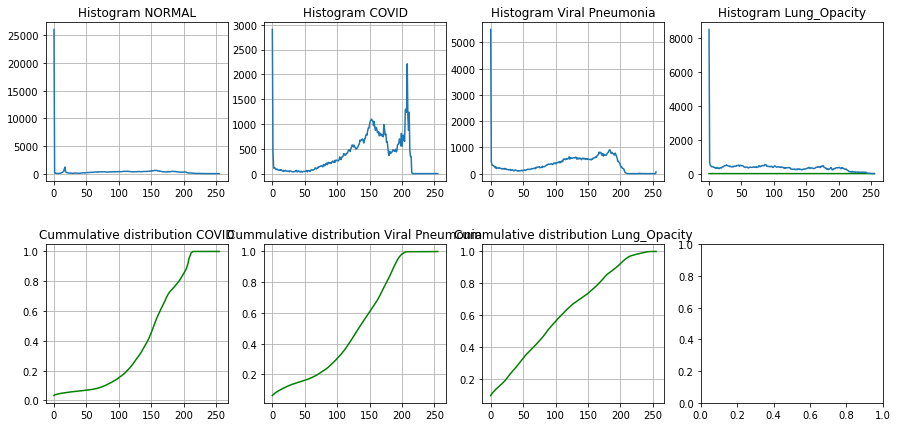

In [142]:
# Data visualization for pixel distribution


fig, ax = plt.subplots(2, 4, figsize=(15, 7))
ax=ax.ravel()
plt.subplots_adjust(hspace=0.4)

for i,_dir in enumerate(['NORMAL/', 'COVID/', 'Viral Pneumonia/', 'Lung_Opacity/']):
    im_file = os.listdir(input_path+_dir)[0]
    full_path = input_path+_dir+im_file
    im=imageio.imread(full_path)
    hist=ndi.histogram(im, min=0, max=255, bins=256)
    cdf = hist.cumsum() / hist.sum()
    ax[i].plot(hist)
    ax[i].set_title(f'Histogram {_dir[:-1]}')
    ax[i].grid()
    ax[i+3].plot(cdf, 'g')
    ax[i+3].set_title(f'Cummulative distribution {_dir[:-1]}')
    ax[i+3].grid()

In [65]:
# Creating folders for train and test samples

if os.path.isdir('training'):
    shutil.rmtree('training')
if os.path.isdir('training/train'):
    shutil.rmtree('training/train')
if os.path.isdir('training/test/'):
    shutil.rmtree('training/test')

os.mkdir('training/')
# os.mkdir('training/train')
os.mkdir('training/test')

shutil.copytree(input_path, 'training/train')


In [72]:
# Checking how many files we have in the newest folders

# Removing excelsheets 
if os.path.isfile('training/train/COVID.metadata.xlsx'):
    os.remove('training/train/COVID.metadata.xlsx')
if os.path.isfile('training/train/README.md.txt'):
    os.remove('training/train/README.md.txt')
if os.path.isfile('training/train/Viral Pneumonia.metadata.xlsx'):
    os.remove('training/train/Viral Pneumonia.metadata.xlsx')
if os.path.isfile('training/train/NORMAL.metadata.xlsx'):
    os.remove('training/train/NORMAL.metadata.xlsx')
if os.path.isfile('training/train/Lung_Opacity.metadata.xlsx'):
    os.remove('training/train/Lung_Opacity.metadata.xlsx')

cnt_files=0
os.listdir('training/train')
for file in {'COVID', 'NORMAL', 'Viral Pneumonia', 'Lung_Opacity'}:
    for files in os.listdir(os.path.join('training/train/',file)):
        cnt_files += 1
print(cnt_files)

21165


In [77]:
# Performing data train/test split

split_percentage = 0.3 # 30% Testing, 70% training

src = 'training/train'
dst = 'training/test'

if os.path.isdir('training/test/COVID'):
    shutil.rmtree('training/test/COVID')
if os.path.isdir('training/test/Viral Pneumonia'):
    shutil.rmtree('training/test/Viral Pneumonia')
if os.path.isdir('training/test/NORMAL'):
    shutil.rmtree('training/test/NORMAL')
if os.path.isdir('training/test/Lung_Opacity'):
    shutil.rmtree('training/test/Lung_Opacity')

os.mkdir('training/test/COVID')
os.mkdir('training/test/Viral Pneumonia')
os.mkdir('training/test/NORMAL')
os.mkdir('training/test/Lung_Opacity')

split_length = int(cnt_files * split_percentage)
total_files_copied = 0
for folders in os.listdir(src):
    dir = os.path.join(src, folders)
    cut_length = len([name for name in os.listdir(dir) if os.path.isfile(os.path.join(dir, name))]) * split_percentage
    count=0
    for files in os.listdir(dir):
        shutil.move(os.path.join(src, folders, files), os.path.join(dst, folders, files))
        if count >= cut_length:
            break
        total_files_copied += 1
        count += 1

print(f"Expected Files: {cnt_files * split_percentage} \nCopied Files: {total_files_copied} ({total_files_copied / cnt_files * 100})")

Expected Files: 6349.5 
Copied Files: 6351 (30.007087172218284)


## Relevant Variables

In [97]:
# Defining some constant variables to use in the preprocessor
train_path  = 'training/train'
test_path =  'training/test'
IMAGE_SIZE    = (250, 250) # 150x150 (height, width) pixels
NUM_CLASSES   = 4 #COVID, NORMAL, PNEUMONIA, LungOpacity (Potential Metastasis)
BATCH_SIZE    = 32  # try reducing batch size or freeze more layers if your GPU runs out of memory
NUM_EPOCHS    = 20 # idem for epochs

## Model

Found 14810 files belonging to 4 classes.
Using 11848 files for training.
Found 14810 files belonging to 4 classes.
Using 2962 files for validation.
['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
0.008331215 0.9589022
Epoch 1/3
371/371 [==============================] - 1394s 4s/step - loss: 0.7529 - accuracy: 0.6974 - val_loss: 0.8668 - val_accuracy: 0.7600
Epoch 2/3
371/371 [==============================] - 1349s 4s/step - loss: 0.4872 - accuracy: 0.8139 - val_loss: 0.5788 - val_accuracy: 0.7890
Epoch 3/3
371/371 [==============================] - 1358s 4s/step - loss: 0.3993 - accuracy: 0.8486 - val_loss: 0.4109 - val_accuracy: 0.8406


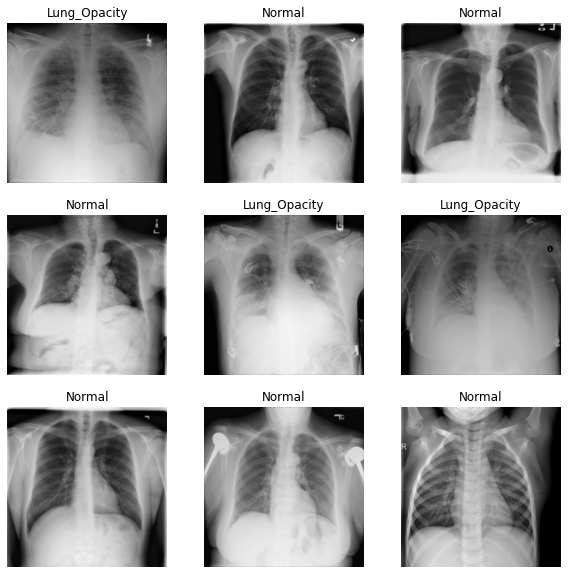

In [120]:
#Train datagen here is a preprocessor

validation_percentage = 0.2

train_ds = tf.keras.utils.image_dataset_from_directory(
    'training/train',
    validation_split=validation_percentage,
    subset="training",
    seed=42,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
    )

val_ds = tf.keras.utils.image_dataset_from_directory(
  'training/train',
  validation_split=validation_percentage,
  subset="validation",
  seed=42,
  image_size=IMAGE_SIZE,
  batch_size=BATCH_SIZE
  )

class_names = train_ds.class_names
print(class_names)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
  tf.keras.layers.MaxPooling2D(2, strides=2),
  tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
  tf.keras.layers.MaxPooling2D(2, strides=2),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.6),
  tf.keras.layers.Conv2D(128, 5, activation='relu', padding='same'),
  tf.keras.layers.MaxPooling2D(2,strides=2),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same'),
  tf.keras.layers.MaxPooling2D(2,strides=2),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Conv2D(256, 5, activation='relu', padding='same'),
  tf.keras.layers.MaxPooling2D(2,strides=2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

result = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_16 (Rescaling)    (None, 250, 250, 3)       0         
                                                                 
 conv2d_65 (Conv2D)          (None, 250, 250, 32)      896       
                                                                 
 max_pooling2d_59 (MaxPoolin  (None, 125, 125, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_66 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_60 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_67 (Conv2D)          (None, 60, 60, 32)      

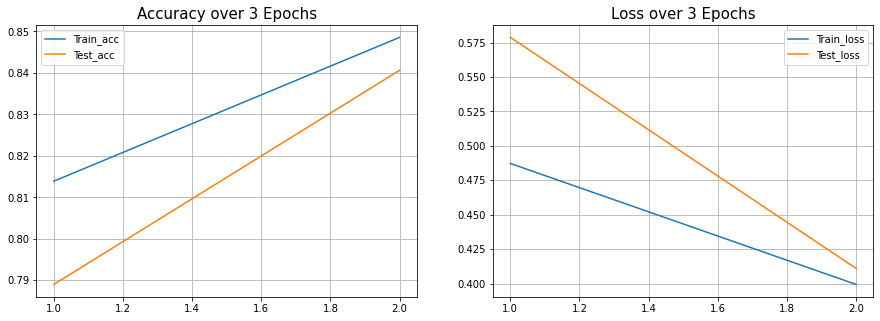

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [128]:
def plot_accs(result, epochs):
    acc = result.history['accuracy']
    loss = result.history['loss']
    val_acc = result.history['val_accuracy']
    val_loss = result.history['val_loss']
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.plot(range(1,epochs), acc[1:], label='Train_acc')
    plt.plot(range(1,epochs), val_acc[1:], label='Test_acc')
    plt.title('Accuracy over ' + str(epochs) + ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.subplot(122)
    plt.plot(range(1,epochs), loss[1:], label='Train_loss')
    plt.plot(range(1,epochs), val_loss[1:], label='Test_loss')
    plt.title('Loss over ' + str(epochs) + ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.show()

model.summary()
# The best accuracy
max(result.history['accuracy'])

plot_accs(result, 3)
plot_model(model, to_file='new_classifier.png', show_shapes=True, show_layer_names=True)